In [1]:
!pip install wget torchinfo
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=8b70287b36bde593db7d1fda7e1d8883409682d689df4fce892663e8ce4bdc1b
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
--2025-02-09 05:44:59--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-02-09 05:45:00--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [3]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [4]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [5]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [7]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [8]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [9]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [10]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [11]:
import torch.nn.functional as F

class LevitStage_TinyFusion(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, num_select, downsample=True):
        super(LevitStage_TinyFusion, self).__init__()
        assert num_select <= num_blocks
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])
        self.num_select = num_select

        init_probs = torch.ones(num_blocks) / num_blocks # uniform distribution
        self.gumble_gate = nn.Parameter(torch.log(init_probs)) # gumble softmax는 log를 취한 값을 사용


    def forward(self, x, tau):
        x = self.downsample(x)

        if self.num_select == 1:
            gate_probs = F.gumble_softmax(self.gumble_gate, tau=tau, hard=True)
            top_k = gate_probs.argmax().item() # k=1

            # forward
            selected_output = self.blocks[top_k](x)

        else:
            soft_probs = F.gumbel_softmax(self.gumble_gate, tau=tau, hard=False)
            top_k = torch.topk(soft_probs, self.num_select).indices # 확률이 높은 상위 k개의 index를 가져옴

            hard_probs = torch.zeros_like(soft_probs)
            hard_probs.scatter_(0, top_k, 1) # 상위 k개의 index에 대해 one-hot encoding
            # Straight-Through Estimator 적용 (Forward 시 hard_probs, Backward 시 soft_probs)
            gate_probs = hard_probs + soft_probs - soft_probs.detach()

            # forward
            selected_output = sum(self.blocks[i](x) * gate_probs[i] for i in top_k)

        # backward
        selected_output = selected_output + (x - selected_output).detach()

        return selected_output


In [12]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [13]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [14]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage_TinyFusion(dim=256, out_dim=256, num_heads=4, num_blocks=4, num_select=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage_TinyFusion(dim=256, out_dim=384, num_heads=6, num_blocks=4, num_select=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x, tau):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x, tau)
        x = self.stage2(x, tau)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [15]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
decay_rate = 1e-6
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage_Tin

In [17]:
print(summary(model, input_size=(32, 3, 224, 224), tau = 10))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [19]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2, tau = 10))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [20]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage_Tin

In [21]:
train_dir = './train/NCT-CRC-HE-100K'

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [23]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [26]:
import json

with open("index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [27]:
train_data = Subset(dataset, load_train_idx)
val_data = Subset(dataset, load_val_idx)
test_data = Subset(dataset, load_test_idx)

In [28]:
g = torch.Generator()
g.manual_seed(42)  # 전체 난수 시퀀스를 고정

train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
    generator=g  # 🔹 DataLoader의 난수 시퀀스를 고정
)

val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False, num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
    generator=g
)

test_loader = DataLoader(
    test_data, batch_size=batch_size, shuffle=False, num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id),
    generator=g
)
print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


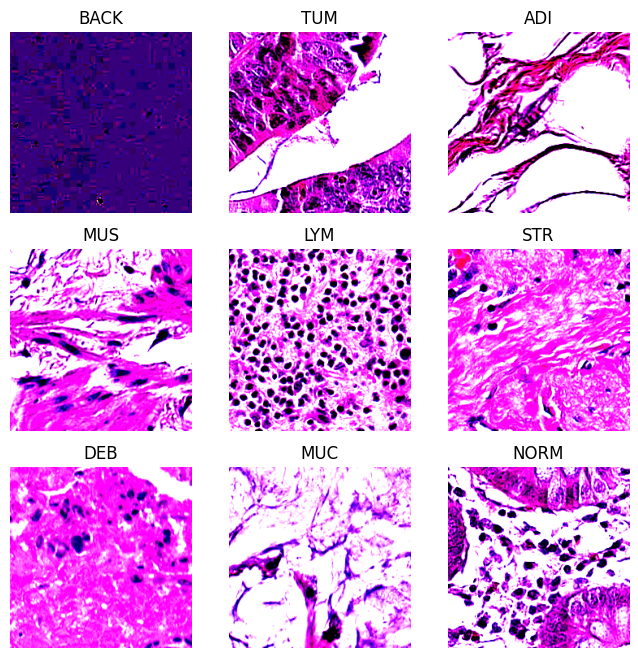

In [29]:
# Show one example per class from the training dataset
import matplotlib.pyplot as plt

# Prepare a dictionary to store one example per class
class_examples = {}
for images, labels in train_loader:
    for img, label in zip(images, labels):
        label = label.item()
        if label not in class_examples:
            class_examples[label] = img
        # Stop if we already have one example for each class
        if len(class_examples) == len(dataset.classes):
            break
    if len(class_examples) == len(dataset.classes):
        break

# Display the images and their labels
figure = plt.figure(figsize=(8, 8))
cols = 3  # You can adjust the number of columns as needed
rows = (len(dataset.classes) + cols - 1) // cols  # Calculate required rows
for i, (label, img) in enumerate(class_examples.items(), start=1):
    figure.add_subplot(rows, cols, i)
    plt.title(dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy())  # Convert tensor to numpy for display
plt.show()

In [30]:
gumbel_params = []
other_params = []

for name, param in model.named_parameters():
    if "gumble_gate" in name:
        gumbel_params.append(param)
    else:
        other_params.append(param)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([
    {'params' : gumbel_params, 'lr': learning_rate * 10, 'weight_decay': decay_rate},
    {'params' : other_params, 'lr': learning_rate, 'weight_decay': decay_rate}
])

In [32]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [33]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    tau = 10

    if epoch % 10 == 0 and epoch != 0:
        tau *= 0.1

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs, tau)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    print("Each stage of block probabilities:")
    for name, module in model.named_modules():
        if isinstance(module, LevitStage_TinyFusion):
            gate_probs = torch.softmax(module.gumble_gate, dim=0) # 각 block의 확률
            topk_indx = torch.topk(gate_probs, module.num_select).indices.tolist() # 상위 k개의 index
            print(f"{name}")
            for i, prob in enumerate(gate_probs):
                mask = " " if i in topk_indx else "*" # mask
                print(f"Block {i}: {prob:.4f} {mask}")

In [35]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    tau = 0.1

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, tau)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

In [45]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs, tau=0.1)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [37]:
# gumbel_gate 파라미터가 포함되어 있는지 확인
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, requires_grad: {param.requires_grad}")

Parameter name: stem.conv1.linear.weight, requires_grad: True
Parameter name: stem.conv1.bn.weight, requires_grad: True
Parameter name: stem.conv1.bn.bias, requires_grad: True
Parameter name: stem.conv2.linear.weight, requires_grad: True
Parameter name: stem.conv2.bn.weight, requires_grad: True
Parameter name: stem.conv2.bn.bias, requires_grad: True
Parameter name: stem.conv3.linear.weight, requires_grad: True
Parameter name: stem.conv3.bn.weight, requires_grad: True
Parameter name: stem.conv3.bn.bias, requires_grad: True
Parameter name: stem.conv4.linear.weight, requires_grad: True
Parameter name: stem.conv4.bn.weight, requires_grad: True
Parameter name: stem.conv4.bn.bias, requires_grad: True
Parameter name: stage1.gumble_gate, requires_grad: True
Parameter name: stage1.blocks.0.attn.attention_biases, requires_grad: True
Parameter name: stage1.blocks.0.attn.qkv.linear.weight, requires_grad: True
Parameter name: stage1.blocks.0.attn.qkv.bn.weight, requires_grad: True
Parameter name: s

In [39]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [01:17<00:00, 28.21it/s]


Train Loss: 0.6406, Train Accuracy: 77.38%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.2492  
Block 2: 0.0001 *
Block 3: 0.7507  
stage2
Block 0: 0.9695  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0305  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.25it/s]


Validation Loss: 0.4866, Validation Accuracy: 82.65%
Balanced Accuracy: 0.8117

Epoch 2/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 29.01it/s]


Train Loss: 0.3760, Train Accuracy: 87.00%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0770  
Block 2: 0.0000 *
Block 3: 0.9230  
stage2
Block 0: 0.9882  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0118  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.57it/s]


Validation Loss: 0.2536, Validation Accuracy: 91.79%
Balanced Accuracy: 0.9171

Epoch 3/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.75it/s]


Train Loss: 0.2956, Train Accuracy: 89.88%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0161  
Block 2: 0.0000 *
Block 3: 0.9839  
stage2
Block 0: 0.9988  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0012  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.06it/s]


Validation Loss: 0.2565, Validation Accuracy: 90.94%
Balanced Accuracy: 0.9088

Epoch 4/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 28.93it/s]


Train Loss: 0.2544, Train Accuracy: 91.25%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0032  
Block 2: 0.0000 *
Block 3: 0.9968  
stage2
Block 0: 0.9998  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0002  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.67it/s]


Validation Loss: 0.2523, Validation Accuracy: 91.47%
Balanced Accuracy: 0.9150

Epoch 5/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 28.96it/s]


Train Loss: 0.2287, Train Accuracy: 92.17%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0004  
Block 2: 0.0000 *
Block 3: 0.9996  
stage2
Block 0: 0.9999  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0001  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.73it/s]


Validation Loss: 0.3781, Validation Accuracy: 88.27%
Balanced Accuracy: 0.8746

Epoch 6/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 28.94it/s]


Train Loss: 0.2036, Train Accuracy: 93.03%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0001  
Block 2: 0.0000 *
Block 3: 0.9999  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.51it/s]


Validation Loss: 0.2182, Validation Accuracy: 92.68%
Balanced Accuracy: 0.9284

Epoch 7/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 28.88it/s]


Train Loss: 0.1860, Train Accuracy: 93.70%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.72it/s]


Validation Loss: 0.1502, Validation Accuracy: 95.05%
Balanced Accuracy: 0.9512

Epoch 8/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.60it/s]


Train Loss: 0.1706, Train Accuracy: 94.25%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.35it/s]


Validation Loss: 0.1759, Validation Accuracy: 93.83%
Balanced Accuracy: 0.9382

Epoch 9/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.51it/s]


Train Loss: 0.1627, Train Accuracy: 94.46%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.67it/s]


Validation Loss: 0.2161, Validation Accuracy: 92.57%
Balanced Accuracy: 0.9208

Epoch 10/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.50it/s]


Train Loss: 0.1494, Train Accuracy: 94.87%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.13it/s]


Validation Loss: 0.1077, Validation Accuracy: 96.36%
Balanced Accuracy: 0.9630

Epoch 11/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.70it/s]


Train Loss: 0.1395, Train Accuracy: 95.32%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.93it/s]


Validation Loss: 0.1218, Validation Accuracy: 96.15%
Balanced Accuracy: 0.9608

Epoch 12/30


Training: 100%|██████████| 2188/2188 [01:17<00:00, 28.31it/s]


Train Loss: 0.1320, Train Accuracy: 95.51%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.78it/s]


Validation Loss: 0.1106, Validation Accuracy: 96.35%
Balanced Accuracy: 0.9624

Epoch 13/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.62it/s]


Train Loss: 0.1350, Train Accuracy: 95.39%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.92it/s]


Validation Loss: 0.0885, Validation Accuracy: 97.09%
Balanced Accuracy: 0.9709

Epoch 14/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 29.09it/s]


Train Loss: 0.1276, Train Accuracy: 95.69%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.01it/s]


Validation Loss: 0.1230, Validation Accuracy: 95.80%
Balanced Accuracy: 0.9569

Epoch 15/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.61it/s]


Train Loss: 0.1207, Train Accuracy: 95.89%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.23it/s]


Validation Loss: 0.1229, Validation Accuracy: 95.91%
Balanced Accuracy: 0.9580

Epoch 16/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.66it/s]


Train Loss: 0.1126, Train Accuracy: 96.10%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.98it/s]


Validation Loss: 0.1043, Validation Accuracy: 96.53%
Balanced Accuracy: 0.9649

Epoch 17/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.70it/s]


Train Loss: 0.1103, Train Accuracy: 96.23%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.04it/s]


Validation Loss: 0.1163, Validation Accuracy: 96.17%
Balanced Accuracy: 0.9608

Epoch 18/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.49it/s]


Train Loss: 0.1098, Train Accuracy: 96.24%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.67it/s]


Validation Loss: 0.0888, Validation Accuracy: 96.96%
Balanced Accuracy: 0.9700

Epoch 19/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.62it/s]


Train Loss: 0.0970, Train Accuracy: 96.71%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.70it/s]


Validation Loss: 0.0906, Validation Accuracy: 96.89%
Balanced Accuracy: 0.9675

Epoch 20/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.79it/s]


Train Loss: 0.0979, Train Accuracy: 96.67%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.98it/s]


Validation Loss: 0.0967, Validation Accuracy: 96.73%
Balanced Accuracy: 0.9662

Epoch 21/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.70it/s]


Train Loss: 0.0988, Train Accuracy: 96.55%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.58it/s]


Validation Loss: 0.0939, Validation Accuracy: 96.71%
Balanced Accuracy: 0.9666

Epoch 22/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.67it/s]


Train Loss: 0.0906, Train Accuracy: 96.96%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.47it/s]


Validation Loss: 0.0811, Validation Accuracy: 97.24%
Balanced Accuracy: 0.9716

Epoch 23/30


Training: 100%|██████████| 2188/2188 [01:15<00:00, 28.86it/s]


Train Loss: 0.0921, Train Accuracy: 96.93%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 47.72it/s]


Validation Loss: 0.1135, Validation Accuracy: 96.15%
Balanced Accuracy: 0.9606

Epoch 24/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.63it/s]


Train Loss: 0.0847, Train Accuracy: 97.09%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.13it/s]


Validation Loss: 0.0966, Validation Accuracy: 96.74%
Balanced Accuracy: 0.9663

Epoch 25/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.63it/s]


Train Loss: 0.0883, Train Accuracy: 96.97%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.82it/s]


Validation Loss: 0.0859, Validation Accuracy: 97.07%
Balanced Accuracy: 0.9711

Epoch 26/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.43it/s]


Train Loss: 0.0834, Train Accuracy: 97.20%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.57it/s]


Validation Loss: 0.0729, Validation Accuracy: 97.63%
Balanced Accuracy: 0.9760

Epoch 27/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.77it/s]


Train Loss: 0.0863, Train Accuracy: 96.93%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.35it/s]


Validation Loss: 0.0944, Validation Accuracy: 96.85%
Balanced Accuracy: 0.9662

Epoch 28/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.62it/s]


Train Loss: 0.0808, Train Accuracy: 97.27%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 49.00it/s]


Validation Loss: 0.0893, Validation Accuracy: 97.02%
Balanced Accuracy: 0.9691

Epoch 29/30


Training: 100%|██████████| 2188/2188 [01:17<00:00, 28.29it/s]


Train Loss: 0.0794, Train Accuracy: 97.28%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 50.27it/s]


Validation Loss: 0.0876, Validation Accuracy: 97.17%
Balanced Accuracy: 0.9705

Epoch 30/30


Training: 100%|██████████| 2188/2188 [01:16<00:00, 28.65it/s]


Train Loss: 0.0731, Train Accuracy: 97.44%
Each stage of block probabilities:
stage1
Block 0: 0.0000 *
Block 1: 0.0000  
Block 2: 0.0000 *
Block 3: 1.0000  
stage2
Block 0: 1.0000  
Block 1: 0.0000 *
Block 2: 0.0000 *
Block 3: 0.0000  


Validation: 100%|██████████| 469/469 [00:09<00:00, 48.45it/s]

Validation Loss: 0.0750, Validation Accuracy: 97.64%
Balanced Accuracy: 0.9754


In [40]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:09<00:00, 49.05it/s]

Test Loss: 0.0763, Test Accuracy: 97.32%
Balanced Accuracy: 0.9723


In [41]:
print("train_loss length : ", len(train_losses))
print("train_acc length : ", len(train_accuracies))
print("val_loss length : ", len(val_losses))
print("val_acc length : ", len(val_accuracies))

print("val_adj : ", len(val_losses[:num_epochs]))
print("val_acc_adj : ", len(val_accuracies[:num_epochs]))

train_loss length :  30
train_acc length :  30
val_loss length :  31
val_acc length :  31
val_adj :  30
val_acc_adj :  30


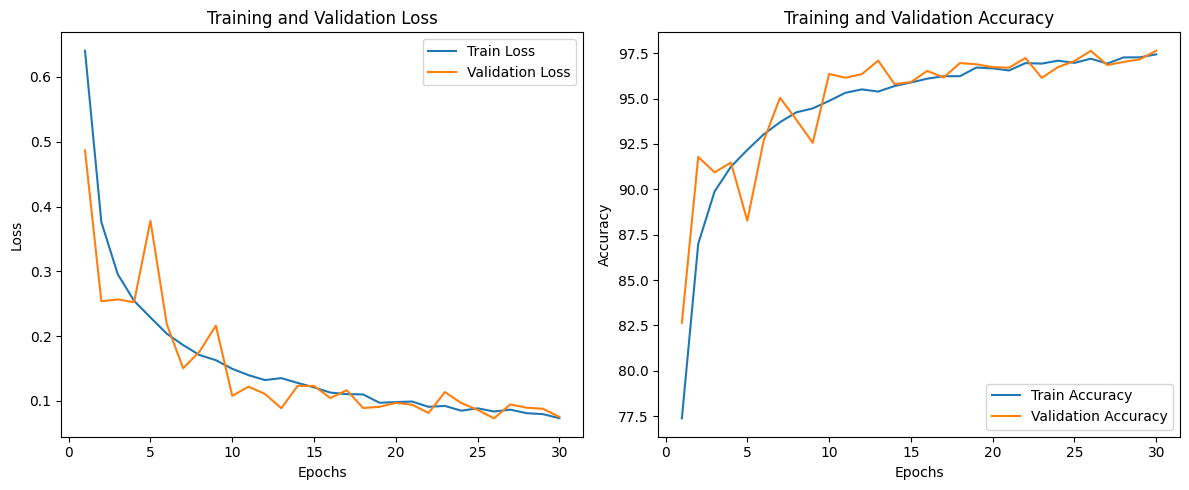

In [42]:
# Plot the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses[:num_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies[:num_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 7.93 ms
Standard Deviation: 0.85 ms
Maximum Time: 18.68 ms
Minimum Time: 7.22 ms


In [48]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input, tau=0.1)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         2.05%     337.492us        14.31%       2.360ms      98.314us       0.000us         0.00%       2.529ms     105.377us            24  
                                           aten::linear         0.58%      95.681us         8.74%       1.442ms      80.119us       0.000us         0.00%       1.828ms     101.537us            18  
         

In [49]:
save_path = "HoViT_44_NCT-CRC-HE-100K.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

Model weights saved to HoViT_44_NCT-CRC-HE-100K.pth


In [53]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, tau=0.1)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    val_losses.append(epoch_loss)
    val_accuracies.append(accuracy)

    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [51]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [54]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:10<00:00, 46.09it/s]

Test Loss: 0.0763, Test Accuracy: 97.32%
Overall - F1: 0.9728, Recall: 0.9723, Precision: 0.9735
Per-Class Metrics:
Class 0 - F1: 0.9904, Recall: 0.9949, Precision: 0.9860
Class 1 - F1: 0.9950, Recall: 0.9956, Precision: 0.9943
Class 2 - F1: 0.9614, Recall: 0.9653, Precision: 0.9575
Class 3 - F1: 0.9962, Recall: 0.9925, Precision: 1.0000
Class 4 - F1: 0.9657, Recall: 0.9498, Precision: 0.9822
Class 5 - F1: 0.9742, Recall: 0.9749, Precision: 0.9734
Class 6 - F1: 0.9702, Recall: 0.9650, Precision: 0.9754
Class 7 - F1: 0.9284, Recall: 0.9349, Precision: 0.9220
Class 8 - F1: 0.9740, Recall: 0.9776, Precision: 0.9704


<Figure size 2000x1200 with 0 Axes>

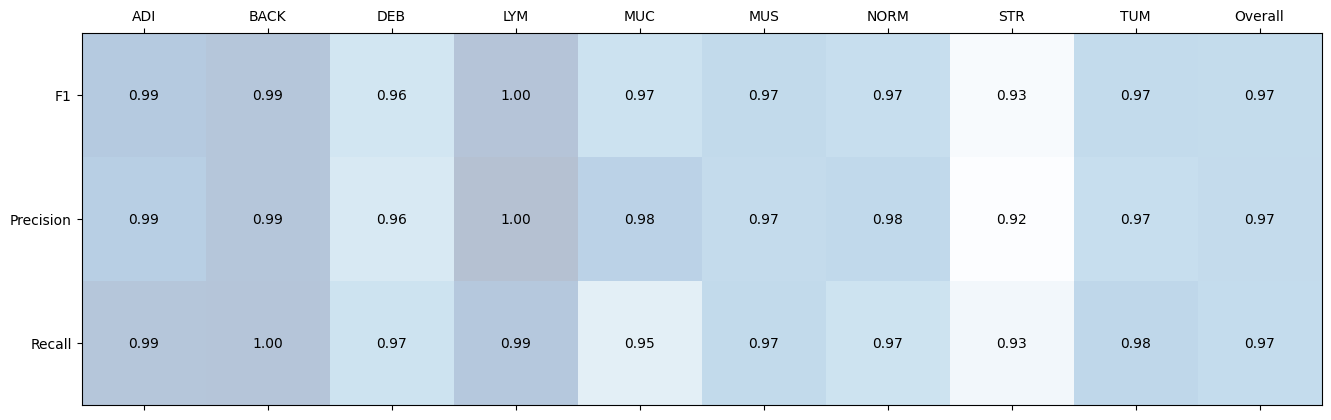

In [55]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )

In [60]:
import copy

def pruning_model(model):
    copy_model = copy.deepcopy(model)

    selected_blocks = {}

    for name, module in model.named_modules():
        if isinstance(module, LevitStage_TinyFusion):
            gate_probs = torch.softmax(module.gumble_gate, dim=0)
            topk_indx = torch.topk(gate_probs, module.num_select).indices.tolist()
            selected_blocks[name] = topk_indx
            print(f"{name} : Top-{module.num_select} blocks: {topk_indx}")

    for name, module in copy_model.named_modules():
        if isinstance(module, LevitStage_TinyFusion):
            topk_indx = selected_blocks[name]

            # 🔹 pruning 후에도 index를 유지할 수 있도록 딕셔너리로 변환
            new_blocks_dict = {i: module.blocks[i] for i in topk_indx}

            # 🔹 블록을 새로운 nn.Sequential로 재구성
            module.blocks = nn.Sequential(*new_blocks_dict.values())

            # 🔹 pruning 후 index를 매핑 (리스트로 저장)
            module.selected_indices = topk_indx

    return copy_model


In [61]:
pruning_model = pruning_model(model)

stage1 : Top-2 blocks: [3, 1]
stage2 : Top-2 blocks: [0, 3]


In [62]:
times = measure_inference_time(pruning_model, test_loader, device)

IndexError: index 3 is out of range

In [59]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(pruning_model, test_loader, criterion, device, phase="Test")

Test:   0%|          | 0/469 [00:00<?, ?it/s]


IndexError: index 3 is out of range

In [ ]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )